# RapidWright Tutorial - Probe Re-router
In this Jupyter notebook tutorial, we illustrate how to: 
 1. Locate existing ILAs in a placed and routed design
 2. Use RapidWright to unroute and re-route probe connections--preserving implementation
 
## Background
Vivado provides an integrated logic analyzer (ILA) IP for providing debugging and visibility into implemented FPGA designs. The user attaches probes to existing nets in the synthesized design to observe them at runtime.  Vivado offers a path to change the probes after place and route (see [Vivado ECO Flow, p.153](https://www.xilinx.com/support/documentation/sw_manuals/xilinx2018_3/ug904-vivado-implementation.pdf)).  In many cases, this is the recommended path.  However, there are two scenarios where RapidWright may offer a valuable alternative:

1. When routing must be preserved in order to replicate faulty behavior. 
2. The time to incrementally re-route the probes impacts productivity.

RapidWright's `ProbeRouter` mitigates these issues by providing a non-invasive un-route/re-route option and by leveraging RapidWright's speed and agility in modifying a design.  The `ProbeRouter` will only un-route the branch segment of a net that leads to the probe and leave all other routing intact.  This is designed with minimal impact to the timing characteristics of the design.  


## Get Started!
To begin, this tutorial starts with an already placed and routed design that has already been instrumented with an ILA.  We can go ahead and load the DCP in the code cell below:

In [1]:
# Get our imports loaded for this session
from com.xilinx.rapidwright.debug import ProbeRouter
from com.xilinx.rapidwright.design import Design
from java.util import Collections
from java.util import HashMap
from pprint import pprint

# read our checkpoint and keep a handle to the design
design = Design.readCheckpoint("microblaze_with_ila_routed.dcp")

# create an empty Java HashMap (to pass as a parameter later)
probesMap = HashMap()

# keep a handle to our EDIF Netlist
netlist = design.getNetlist()

If we don't know where the ILA is located in the netlist, the `ProbeRouter` has a built in API that can search for it in the hierarchy:

In [2]:
ProbeRouter.findILAs(design)

[u_ila_0]

Once we have selected an ILA (there could be more than one in the design), we can query it for its available probes.  

In [3]:
netlist.getCellInstFromHierName("u_ila_0").getCellPorts()

[clk, SL_IPORT_I[0:36], SL_OPORT_O[0:16], probe0[8:0], probe1[3:0], probe2[31:0], probe3[3:0], probe4[3:0], probe5[31:0]]

If we are curious as to what that probe is currently connected to, we can query the probe's net and/or get all of its net aliases:

In [4]:
# Get the net connected to the probe port instance
net = netlist.getCellInstFromHierName("u_ila_0").getPortInst("probe0[4]").getNet()

# Method to traverse netlist and extract net aliases from the netlist
netAliases = netlist.getNetAliases(net.getName())

# Extra Python code to print the net and aliases
Collections.sort(netAliases)
print "Connected net = '" + str(net) + "'\\n"
print "Net aliases ="
pprint([x.encode('ascii') for x in netAliases])

Connected net = 'u_ila_0_microblaze_0_axi_periph_M01_AXI_AWADDR[4]'

Net aliases =
['base_mb_i/microblaze_0_axi_periph/M01_AXI_awaddr[4]',
 'base_mb_i/microblaze_0_axi_periph/xbar/inst/gen_sasd.crossbar_sasd_0/Q[4]',
 'base_mb_i/microblaze_0_axi_periph/xbar/inst/gen_sasd.crossbar_sasd_0/addr_arbiter_inst/Q[4]',
 'base_mb_i/microblaze_0_axi_periph/xbar/inst/m_axi_araddr[4]',
 'base_mb_i/microblaze_0_axi_periph/xbar/m_axi_awaddr[36]',
 'base_mb_i/microblaze_0_axi_periph_M01_AXI_AWADDR[4]',
 'u_ila_0/inst/probe0[4]',
 'u_ila_0/probe0[4]',
 'u_ila_0_microblaze_0_axi_periph_M01_AXI_AWADDR[4]']


We can compare this result with the same design loaded in Vivado and can see the full schematic view below:

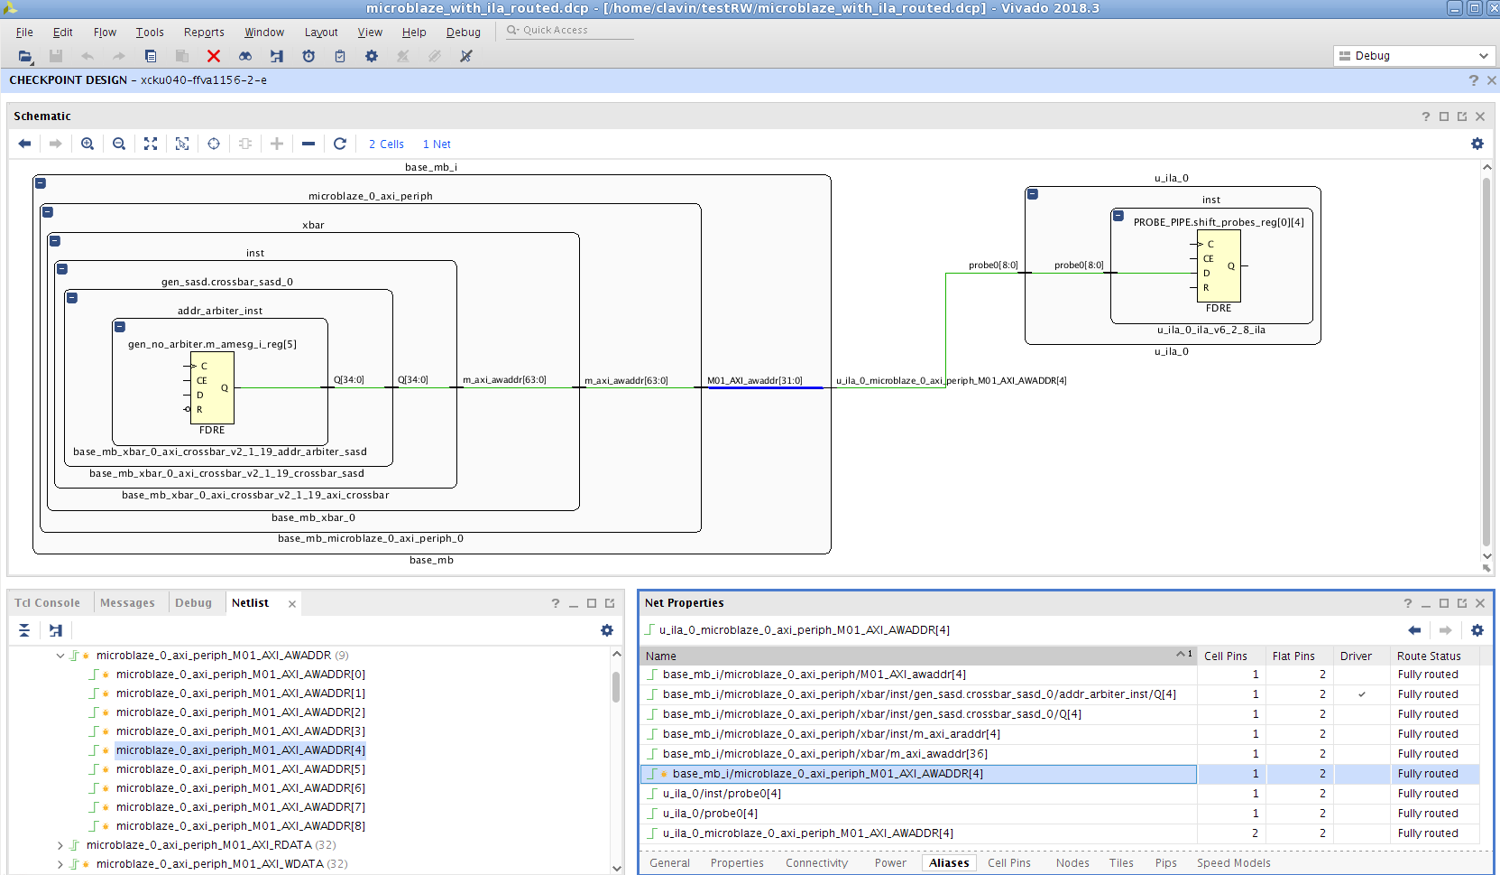

> ***OPTIONAL:*** To see this schematic view in Vivado, do the following: <br/>
> Run these commands in Tcl:<br/>
>> `open_checkpoint "<path_to_your_copy>/microblaze_with_ila_routed.dcp"`<br/>
>> `select_objects [get_nets 'u_ila_0_microblaze_0_axi_periph_M01_AXI_AWADDR[4]']`<br/>
> 
> Then in the GUI, press `F4` to load the net into the schematic view<br/>
> Right click on the blue highlighted net, choose `Expand Cone`->`To Leaf Cells`<br/>
> You may need to zoom out (`Ctrl+Minus` key) to position it properly

Suppose we want to change this probe's connect to another net, we can tell the `ProbeRouter` to re-route the probe to another net such as "base_mb_i/axi_uartlite_0/U0/AXI_LITE_IPIF_I/I_SLAVE_ATTACHMENT/bus2ip_rnw_i":

In [5]:
# Probe input name -> Desired net name to debug
probesMap.put("u_ila_0/probe0[4]", "base_mb_i/axi_uartlite_0/U0/AXI_LITE_IPIF_I/I_SLAVE_ATTACHMENT/bus2ip_rnw_i")

# Invoke the probe re-router to un-route existing connection, route to net(s) specified
ProbeRouter.updateProbeConnections(design,probesMap)

design.writeCheckpoint("microblaze_updated_probe.dcp")

Now we can re-run the code from above to examine the new connectivity:

In [6]:
# Get the net connected to the probe port instance
net = netlist.getCellInstFromHierName("u_ila_0").getPortInst("probe0[4]").getNet()

# Method to traverse netlist and extract net aliases from the netlist
netAliases = netlist.getNetAliases(net.getName())

# Extra Python code to print the net and aliases
Collections.sort(netAliases)
print "Connected net = '" + str(net) + "'\\n"
print "Net aliases ="
pprint([x.encode('ascii') for x in netAliases])

Connected net = 'rw_probe0[4]'

Net aliases =
['base_mb_i/axi_uartlite_0/U0/AXI_LITE_IPIF_I/I_SLAVE_ATTACHMENT/I_DECODER/bus2ip_rnw_i',
 'base_mb_i/axi_uartlite_0/U0/AXI_LITE_IPIF_I/I_SLAVE_ATTACHMENT/bus2ip_rnw_i',
 'base_mb_i/axi_uartlite_0/U0/AXI_LITE_IPIF_I/rw_probe0[4]',
 'base_mb_i/axi_uartlite_0/U0/rw_probe0[4]',
 'base_mb_i/axi_uartlite_0/rw_probe0[4]',
 'base_mb_i/rw_probe0[4]',
 'rw_probe0[4]',
 'u_ila_0/inst/probe0[4]',
 'u_ila_0/probe0[4]']


Again, here is the Vivado view of the new probed net for comparison:

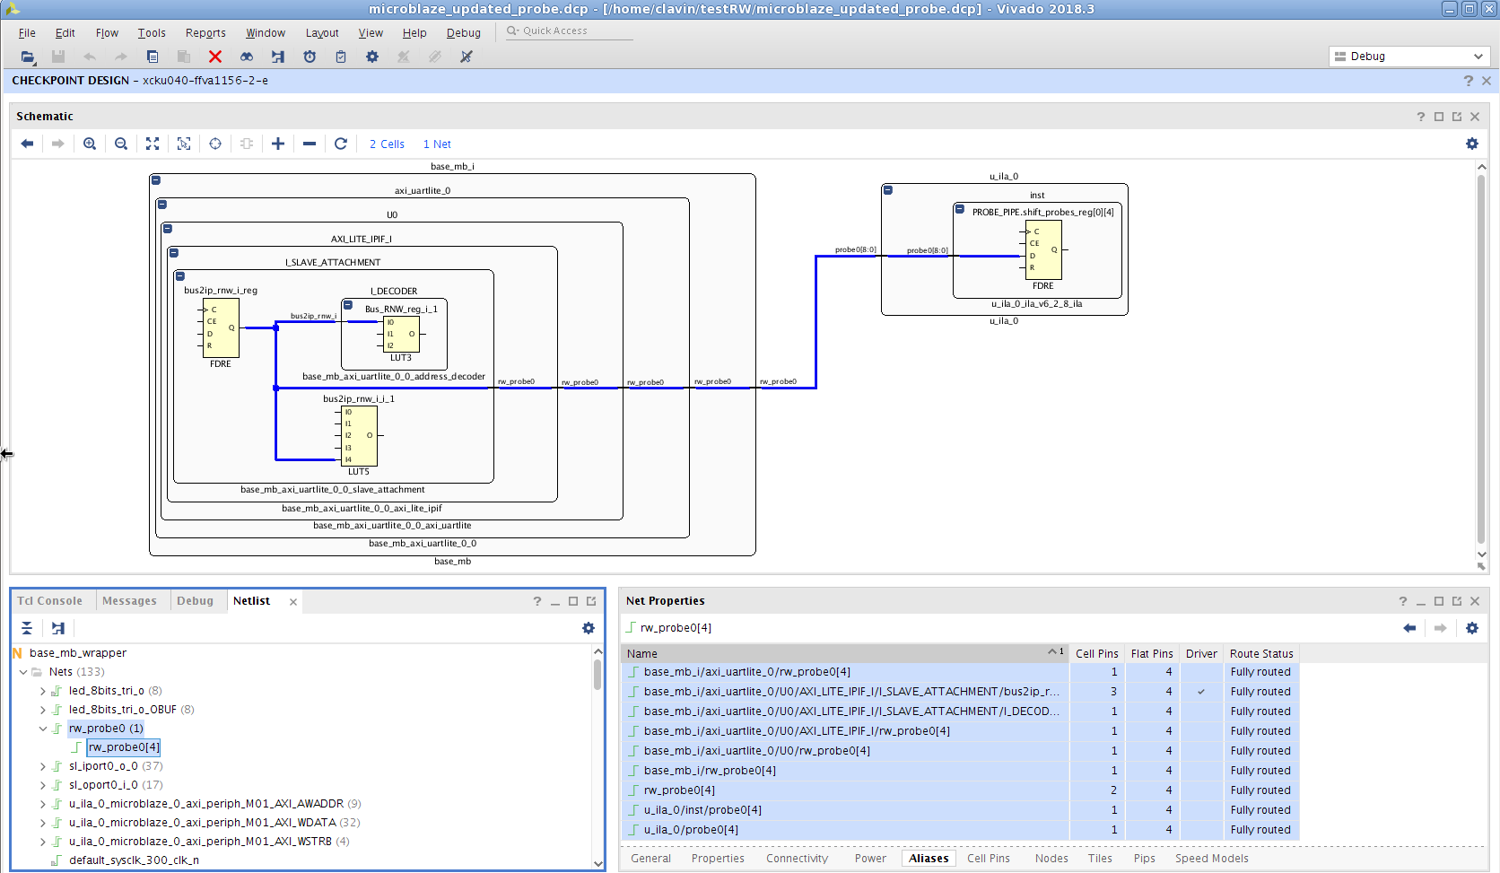

## Some Quick Exercises

1. Use Vivado to choose some nets of your own to probe and add them to the `probesMap` above.  


2. Try comparing an existing probed routed net with the net after the probe has been removed (you'll need to open both DCPs in Vivado).  Does the remaining part of the route stay intact?
> ***HINT:***<br/>
> To compare the routing of two nets visually, you may want to highlight it.  Follow these steps:
> 1. Open one of the DCPs in the Vivado GUI
> 2. Open the Device window if it is not already open (`Window->Device`)
> 3. Select the net with the Tcl command: `select_objects [get_nets <net_name>]`
> 4. Right click on the selected net in the Device window and choose `Highlight->(choose a color)`
> 5. You can also mark pins by choosing the `Cell Pins` tab in the `Net Properties` window by right clicking on a pin and choosing `Mark->(choose a color)`.  A mark will stay visible at any zoom level.
> Here is an example comparison:
> 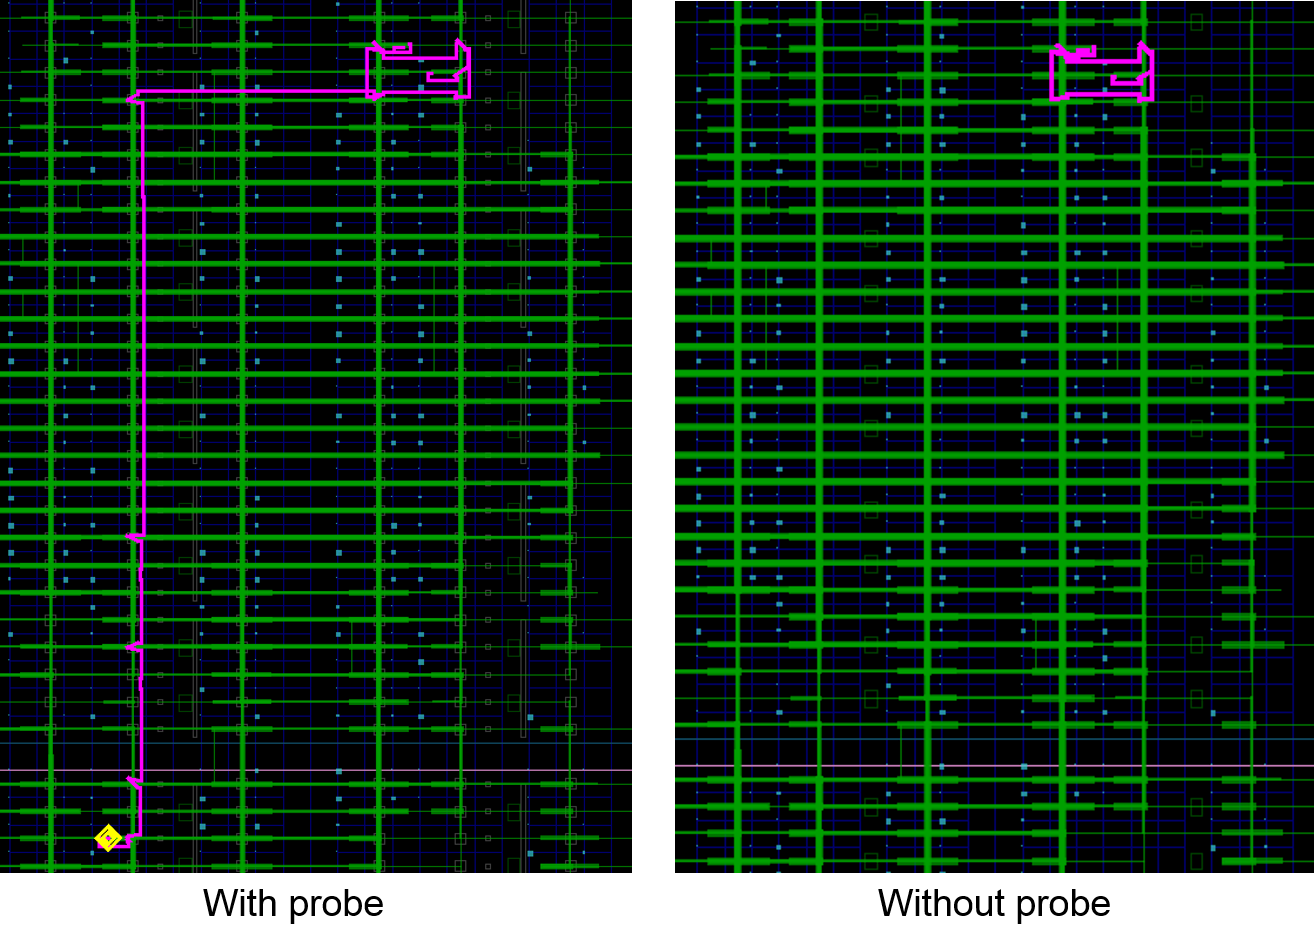